In [61]:
import sys, os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from keras.layers import Dense, Dropout, SimpleRNN, LSTM
from keras.models import Sequential
from tslearn.preprocessing import TimeSeriesScalerMinMax
sys.path.append(os.path.join(os.path.dirname('Demand_class'), '..', 'src'))
from Demand_class import Demand
plt.style.use('seaborn-darkgrid')

In [4]:
path = '../data/demand_lower_48'

In [22]:
nat_dem = Demand()

In [23]:
nat_dem.load_data(path)

In [24]:
df = nat_dem.dataframe

In [25]:
df.head()

,Time,Megawatthours
0,2015-07-01 02:00:00,335153
1,2015-07-01 03:00:00,333837
2,2015-07-01 04:00:00,398386
3,2015-07-01 05:00:00,388954
4,2015-07-01 06:00:00,392487


In [26]:
lagged_df = nat_dem.create_lag_variables(df, 24)

In [27]:
lagged_df.head()

,Time,Megawatthours,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23
24,2015-07-02 02:00:00,429199,335153,333837,398386,388954,392487,404647,422227,442131,...,587405,594477,595242,586317,572656,554682,543332,520871,485722,453284
25,2015-07-02 03:00:00,407007,333837,398386,388954,392487,404647,422227,442131,464371,...,594477,595242,586317,572656,554682,543332,520871,485722,453284,429199
26,2015-07-02 04:00:00,395194,398386,388954,392487,404647,422227,442131,464371,491512,...,595242,586317,572656,554682,543332,520871,485722,453284,429199,407007
27,2015-07-02 05:00:00,387654,388954,392487,404647,422227,442131,464371,491512,518043,...,586317,572656,554682,543332,520871,485722,453284,429199,407007,395194
28,2015-07-02 06:00:00,390157,392487,404647,422227,442131,464371,491512,518043,540514,...,572656,554682,543332,520871,485722,453284,429199,407007,395194,387654


In [59]:
preds_index = lagged_df['Time'].loc[lagged_df['Time'] >= '2020-03-01 00:00:00']
preds_index = preds_index.values

In [28]:
scaler = MinMaxScaler()

In [29]:
X_train, X_test, y_train, y_test = nat_dem.scale_split(lagged_df, train_test_idx='2020-03-01 00:00:00', scaler=scaler)

In [30]:
X_train, X_test, y_train, y_test = nat_dem.reshape_for_rnn(X_train, X_test, y_train, y_test)

In [31]:
X_train.shape

(40895, 24, 1)

In [32]:
rnn_model = Sequential()
rnn_model

In [33]:
rnn_model.add(SimpleRNN(200, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(200, activation='tanh', return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(200, activation='tanh', return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 24, 200)           40400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 24, 200)           0         
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 24, 200)           80200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 200)           0         
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 200)               80200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [34]:
rnn_model.compile(optimizer='adam', loss='MSE')

In [35]:
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
41/41 [==============================] - 7s 162ms/step - loss: 0.4607
Epoch 2/10
41/41 [==============================] - 7s 160ms/step - loss: 0.1137
Epoch 3/10
41/41 [==============================] - 6s 158ms/step - loss: 0.0481
Epoch 4/10
41/41 [==============================] - 7s 166ms/step - loss: 0.0259
Epoch 5/10
41/41 [==============================] - 7s 164ms/step - loss: 0.0188
Epoch 6/10
41/41 [==============================] - 7s 160ms/step - loss: 0.0155
Epoch 7/10
41/41 [==============================] - 7s 161ms/step - loss: 0.0133
Epoch 8/10
41/41 [==============================] - 7s 159ms/step - loss: 0.0099
Epoch 9/10
41/41 [==============================] - 7s 164ms/step - loss: 0.0088
Epoch 10/10
41/41 [==============================] - 7s 164ms/step - loss: 0.0075


In [36]:
lag_24_preds = rnn_model.predict(X_test)

In [38]:
zeros = np.zeros((len(lag_24_preds), 24))

In [39]:
zeros.shape

(9260, 24)

In [40]:
lag_24_preds_zeros = np.concatenate([lag_24_preds, zeros], axis=1)

In [44]:
lag_24_preds_zeros.shape

(9260, 25)

In [45]:
lag_24_preds_unscaled = scaler.inverse_transform(lag_24_preds_zeros)[:, 0]

In [46]:
lag_24_preds_unscaled

array([443165.15886998, 428513.23372459, 415062.23636985, ...,
       375444.4590193 , 384105.56853473, 393330.11138916])

In [49]:
y_test_zeros = np.concatenate([y_test, zeros], axis=1)

In [50]:
y_test_unscaled = scaler.inverse_transform(y_test_zeros)[:, 0]
y_test_unscaled

array([427034., 414549., 405844., ..., 371950., 379932., 390453.])

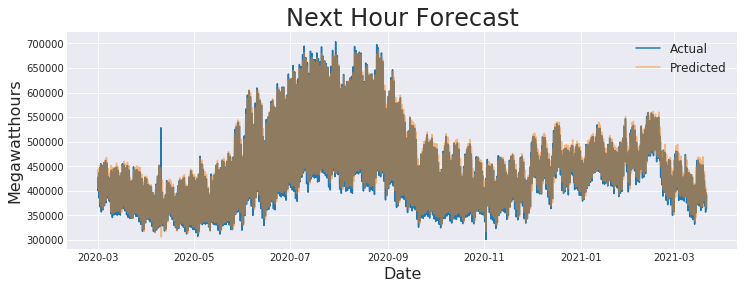

In [89]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(preds_index, y_test_unscaled, label='Actual')
ax.plot(preds_index, lag_24_preds_unscaled, alpha=0.5, label='Predicted')
ax.legend(fontsize=12)
ax.set_xlabel('Date', size=16)
ax.set_ylabel('Megawatthours', size=16)
ax.set_title('Next Hour Forecast', size=24)
plt.savefig('../images/next_hour_rnn.png', dpi=500)

plt.show()

In [54]:
mean_absolute_error(y_test_unscaled, lag_24_preds_unscaled)

8511.445729816269

In [90]:
def mean_abs_percent_error(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred)/y_test)) * 100

In [91]:
mean_abs_percent_error(y_test_unscaled, lag_24_preds_unscaled)

1.9574233248216686

In [53]:
def unscale_y(y_array, scaler, n_lag_variables):
    zeros = np.zeros((len(y_array), n_lag_variables))
    y_with_zeros = np.concatenate([y_array, zeros], axis=1)
    unscaled_y = scaler.inverse_transform(y_with_zeros)[:, 0]
    return unscaled_y

## n-ahead = 24

In [63]:
n_ahead_24 = Demand()

In [64]:
n_ahead_24.load_data(path)

In [65]:
df_24 = n_ahead_24.dataframe

In [66]:
df_24 = n_ahead_24.create_lag_variables(df_24, 24, 24)

In [67]:
df_24.head()

,Time,Megawatthours,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23
48,2015-07-03 02:00:00,415203,335153,333837,398386,388954,392487,404647,422227,442131,...,587405,594477,595242,586317,572656,554682,543332,520871,485722,453284
49,2015-07-03 03:00:00,394227,333837,398386,388954,392487,404647,422227,442131,464371,...,594477,595242,586317,572656,554682,543332,520871,485722,453284,429199
50,2015-07-03 04:00:00,383147,398386,388954,392487,404647,422227,442131,464371,491512,...,595242,586317,572656,554682,543332,520871,485722,453284,429199,407007
51,2015-07-03 05:00:00,373941,388954,392487,404647,422227,442131,464371,491512,518043,...,586317,572656,554682,543332,520871,485722,453284,429199,407007,395194
52,2015-07-03 06:00:00,371552,392487,404647,422227,442131,464371,491512,518043,540514,...,572656,554682,543332,520871,485722,453284,429199,407007,395194,387654


In [68]:
X_train_24, X_test_24, y_train_24, y_test_24 = n_ahead_24.scale_split(df_24, train_test_idx='2020-03-01 00:00:00', scaler=MinMaxScaler())

In [69]:
X_train_24, X_test_24, y_train_24, y_test_24 = n_ahead_24.reshape_for_rnn(X_train_24, X_test_24, y_train_24, y_test_24)

In [70]:
X_train_24.shape

(40871, 24, 1)

In [71]:
rnn_24 = Sequential()

In [75]:
rnn_24.add(SimpleRNN(200, activation='tanh', return_sequences=True, input_shape=(X_train_24.shape[1], 1)))
rnn_24.add(Dropout(0.15))

rnn_24.add(SimpleRNN(200, activation='tanh', return_sequences=True))
rnn_24.add(Dropout(0.15))

rnn_24.add(SimpleRNN(200, activation='tanh', return_sequences=False))
rnn_24.add(Dropout(0.15))

rnn_24.add(Dense(1))

rnn_24.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, 24, 200)           40400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 24, 200)           0         
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 24, 200)           80200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 24, 200)           0         
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 200)               80200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [76]:
rnn_24.compile(optimizer='adam', loss='MSE')

In [77]:
rnn_24.fit(X_train_24, y_train_24, epochs=10, batch_size=1000)

Epoch 1/10
41/41 [==============================] - 7s 166ms/step - loss: 0.6647
Epoch 2/10
41/41 [==============================] - 7s 162ms/step - loss: 0.2004
Epoch 3/10
41/41 [==============================] - 7s 162ms/step - loss: 0.1248
Epoch 4/10
41/41 [==============================] - 7s 160ms/step - loss: 0.0786
Epoch 5/10
41/41 [==============================] - 7s 161ms/step - loss: 0.0513
Epoch 6/10
41/41 [==============================] - 7s 160ms/step - loss: 0.0318
Epoch 7/10
41/41 [==============================] - 7s 160ms/step - loss: 0.0249
Epoch 8/10
41/41 [==============================] - 7s 160ms/step - loss: 0.0208
Epoch 9/10
41/41 [==============================] - 7s 177ms/step - loss: 0.0159
Epoch 10/10
41/41 [==============================] - 7s 161ms/step - loss: 0.0139


In [78]:
ahead_24_preds = rnn_24.predict(X_test_24)

In [79]:
ahead_24_preds_unscaled = unscale_y(ahead_24_preds, scaler, 24)

In [80]:
y_test_24_unscaled = unscale_y(y_test_24, scaler, 24)

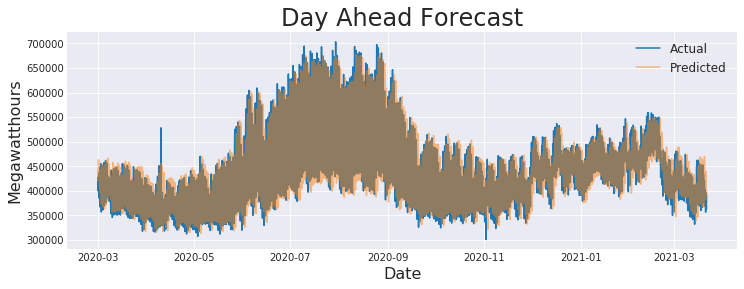

In [88]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(preds_index, y_test_24_unscaled, label='Actual')
ax.plot(preds_index, ahead_24_preds_unscaled, alpha=0.5, label='Predicted')
ax.legend(fontsize=12)
ax.set_xlabel('Date', size=16)
ax.set_ylabel('Megawatthours', size=16)
ax.set_title('Day Ahead Forecast', size=24)
plt.savefig('../images/day_ahead_rnn.png', dpi=500)

plt.show()

In [82]:
mean_absolute_error(y_test_24_unscaled, ahead_24_preds_unscaled)

17206.3033189432

In [92]:
mean_abs_percent_error(y_test_24_unscaled, ahead_24_preds_unscaled)

3.9024527578828403

## Month in advance

In [74]:
month_ahead = Demand()

In [75]:
month_ahead.load_data(path)

In [76]:
n_ahead_720 = month_ahead.dataframe

In [77]:
df_720 = month_ahead.create_lag_variables(n_ahead_720, 720, 720)

In [78]:
df_720.head()

,Time,Megawatthours,0,1,2,3,4,5,6,7,...,710,711,712,713,714,715,716,717,718,719
1440,2015-08-30 02:00:00,415541,335153,333837,398386,388954,392487,404647,422227,442131,...,682163,688288,689487,682378,666540,649856,632088,599934,559580,521564
1441,2015-08-30 03:00:00,397124,333837,398386,388954,392487,404647,422227,442131,464371,...,688288,689487,682378,666540,649856,632088,599934,559580,521564,485347
1442,2015-08-30 04:00:00,382141,398386,388954,392487,404647,422227,442131,464371,491512,...,689487,682378,666540,649856,632088,599934,559580,521564,485347,457572
1443,2015-08-30 05:00:00,372201,388954,392487,404647,422227,442131,464371,491512,518043,...,682378,666540,649856,632088,599934,559580,521564,485347,457572,437938
1444,2015-08-30 06:00:00,367829,392487,404647,422227,442131,464371,491512,518043,540514,...,666540,649856,632088,599934,559580,521564,485347,457572,437938,426952


In [79]:
X_train_720, X_test_720, y_train_720, y_test_720 = month_ahead.scale_split(df_720, train_test_idx='2020-03-01 00:00:00', scaler=MinMaxScaler())

In [80]:
X_train_720, X_test_720, y_train_720, y_test_720 = month_ahead.reshape_for_rnn(X_train_720, X_test_720, y_train_720, y_test_720)

In [81]:
rnn_720 = Sequential()

In [82]:
rnn_720.add(SimpleRNN(200, activation='tanh', return_sequences=True, input_shape=(X_train_720.shape[1], 1)))
rnn_720.add(Dropout(0.15))

rnn_720.add(SimpleRNN(200, activation='tanh', return_sequences=True))
rnn_720.add(Dropout(0.15))

rnn_720.add(SimpleRNN(200, activation='tanh', return_sequences=False))
rnn_720.add(Dropout(0.15))

rnn_720.add(Dense(1))

rnn_720.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_12 (SimpleRNN)    (None, 720, 200)          40400     
_________________________________________________________________
dropout_12 (Dropout)         (None, 720, 200)          0         
_________________________________________________________________
simple_rnn_13 (SimpleRNN)    (None, 720, 200)          80200     
_________________________________________________________________
dropout_13 (Dropout)         (None, 720, 200)          0         
_________________________________________________________________
simple_rnn_14 (SimpleRNN)    (None, 200)               80200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [83]:
rnn_720.compile(optimizer='adam', loss='MSE')

In [84]:
# rnn_720.fit(X_train_720, y_train_720, epochs=10, batch_size=1000)

Epoch 1/10
40/40 [==============================] - 205s 5s/step - loss: 0.4959
Epoch 2/10
40/40 [==============================] - 203s 5s/step - loss: 0.2157
Epoch 3/10
40/40 [==============================] - 202s 5s/step - loss: 0.1725
Epoch 4/10
40/40 [==============================] - 205s 5s/step - loss: 0.1281
Epoch 5/10
40/40 [==============================] - 210s 5s/step - loss: 0.1081
Epoch 6/10
40/40 [==============================] - 208s 5s/step - loss: 0.0930
Epoch 7/10
40/40 [==============================] - 206s 5s/step - loss: 0.0811
Epoch 8/10
40/40 [==============================] - 205s 5s/step - loss: 0.0732
Epoch 9/10
40/40 [==============================] - 205s 5s/step - loss: 0.0671
Epoch 10/10
40/40 [==============================] - 206s 5s/step - loss: 0.0633


In [85]:
# ahead_720_preds = rnn_720.predict(X_test_720)

In [86]:
ahead_720_preds

array([[0.5477178 ],
       [0.5341457 ],
       [0.51582193],
       ...,
       [0.55195224],
       [0.53997684],
       [0.5333997 ]], dtype=float32)

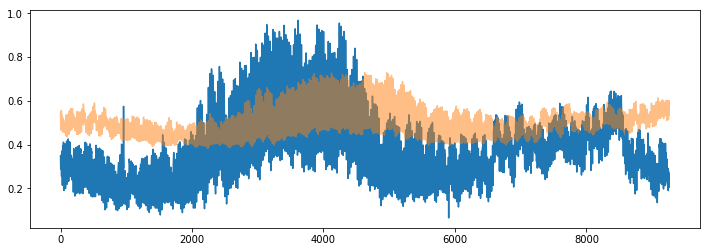

In [87]:
# fig, ax = plt.subplots(figsize=(12, 4))
# ax.plot(range(len(y_test_720)), y_test_720)
# ax.plot(range(len(y_test_720)), ahead_720_preds, alpha=0.5)

# plt.show()

In [88]:
# mean_absolute_error(y_test_720, ahead_720_preds)

0.15760814739307893

## Year ahead

In [3]:
year_ahead = Demand()

In [6]:
year_ahead.load_data(path)

In [7]:
n_ahead_year = year_ahead.dataframe

In [9]:
df_year = year_ahead.create_lag_variables(n_ahead_year, 24, 8760)

In [10]:
df_year.head()

,Time,Megawatthours,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23
8784,2016-07-01 02:00:00,450387,335153,333837,398386,388954,392487,404647,422227,442131,...,587405,594477,595242,586317,572656,554682,543332,520871,485722,453284
8785,2016-07-01 03:00:00,426572,333837,398386,388954,392487,404647,422227,442131,464371,...,594477,595242,586317,572656,554682,543332,520871,485722,453284,429199
8786,2016-07-01 04:00:00,409393,398386,388954,392487,404647,422227,442131,464371,491512,...,595242,586317,572656,554682,543332,520871,485722,453284,429199,407007
8787,2016-07-01 05:00:00,400431,388954,392487,404647,422227,442131,464371,491512,518043,...,586317,572656,554682,543332,520871,485722,453284,429199,407007,395194
8788,2016-07-01 06:00:00,401673,392487,404647,422227,442131,464371,491512,518043,540514,...,572656,554682,543332,520871,485722,453284,429199,407007,395194,387654


In [11]:
X_train_year, X_test_year, y_train_year, y_test_year = year_ahead.scale_split(df_year, train_test_idx='2020-03-01 00:00:00', scaler=MinMaxScaler())

In [12]:
X_train_year, X_test_year, y_train_year, y_test_year = year_ahead.reshape_for_rnn(X_train_year, X_test_year, y_train_year, y_test_year)

In [13]:
rnn_year = Sequential()

In [14]:
rnn_year.add(SimpleRNN(200, activation='tanh', return_sequences=True, input_shape=(X_train_year.shape[1], 1)))
rnn_year.add(Dropout(0.15))

rnn_year.add(SimpleRNN(200, activation='tanh', return_sequences=True))
rnn_year.add(Dropout(0.15))

rnn_year.add(SimpleRNN(200, activation='tanh', return_sequences=False))
rnn_year.add(Dropout(0.15))

rnn_year.add(Dense(1))

rnn_year.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 24, 200)           40400     
_________________________________________________________________
dropout (Dropout)            (None, 24, 200)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 24, 200)           80200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 200)           0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 200)               80200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2

In [15]:
rnn_year.compile(optimizer='adam', loss='MSE')

In [16]:
rnn_year.fit(X_train_year, y_train_year, epochs=10, batch_size=1000)

Epoch 1/10
33/33 [==============================] - 5s 158ms/step - loss: 0.6447
Epoch 2/10
33/33 [==============================] - 5s 157ms/step - loss: 0.2225
Epoch 3/10
33/33 [==============================] - 5s 156ms/step - loss: 0.1403
Epoch 4/10
33/33 [==============================] - 5s 159ms/step - loss: 0.1231
Epoch 5/10
33/33 [==============================] - 5s 158ms/step - loss: 0.0657
Epoch 6/10
33/33 [==============================] - 5s 158ms/step - loss: 0.0427
Epoch 7/10
33/33 [==============================] - 5s 160ms/step - loss: 0.0319
Epoch 8/10
33/33 [==============================] - 5s 159ms/step - loss: 0.0270
Epoch 9/10
33/33 [==============================] - 5s 157ms/step - loss: 0.0235
Epoch 10/10
33/33 [==============================] - 5s 157ms/step - loss: 0.0217


In [17]:
ahead_year_preds = rnn_year.predict(X_test_year)

In [83]:
ahead_year_preds_unscaled = unscale_y(ahead_year_preds, scaler, 24)
ahead_24_preds_unscaled

array([443328.79245895, 431198.33451593, 423050.54879272, ...,
       388883.01538312, 393900.84184784, 399534.24482185])

In [84]:
y_test_year_unscaled = unscale_y(y_test_year, scaler, 24)
y_test_year_unscaled

array([414003.19999672, 400958.77377028, 391863.72128321, ...,
       356451.00342027, 364790.6598191 , 375783.08339366])

In [86]:
mean_absolute_error(y_test_year_unscaled, ahead_year_preds_unscaled)

35267.97103160479

In [94]:
mean_abs_percent_error(y_test_year_unscaled, ahead_year_preds_unscaled)

8.527480928937113

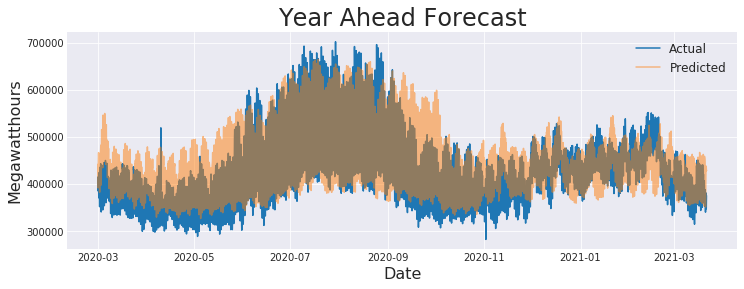

In [87]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(preds_index, y_test_year_unscaled, label='Actual')
ax.plot(preds_index, ahead_year_preds_unscaled, alpha=0.5, label='Predicted')
ax.legend(fontsize=12)
ax.set_xlabel('Date', size=16)
ax.set_ylabel('Megawatthours', size=16)
ax.set_title('Year Ahead Forecast', size=24)
plt.savefig('../images/year_ahead_rnn.png', dpi=500)
plt.show()